In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [3]:
from triplet_dataset import PairDataset

In [4]:
train_ds = torch.load("data/train_dataset.pt")
eval_ds = torch.load("data/eval_dataset.pt")

In [5]:
# train_ds.reshuffle()
# eval_ds.reshuffle()

In [6]:
len(eval_ds.data), len(eval_ds.labels), len(eval_ds.pairs)

(52270, 52270, 52270)

In [7]:
eval_set_size = 30_000

In [8]:
eval_ds.data = eval_ds.data[:eval_set_size]
eval_ds.labels = eval_ds.labels[:eval_set_size]
eval_ds.pairs = eval_ds.pairs[:eval_set_size]

In [9]:
def get_majority(ds, get_value_counts=False):
    """Returns accuracy of the majority classifier"""
    # Get the labels from the dataset
    labels = [ys[0] for Xs, ys in ds.pairs]
    
    # Calculate the majority class label and its count
    majority_class = np.argmax(np.bincount(labels))
    majority_class_count = np.sum(labels == majority_class)
    
    # Calculate the accuracy of the majority classifier
    accuracy = majority_class_count / len(labels)
    
    if get_value_counts:
        return majority_class, accuracy, np.bincount(labels)
    
    return majority_class, accuracy

In [10]:
print(get_majority(train_ds))

(1028, 0.003733165575412428)


In [11]:
BATCH_SIZE = 256

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
(a, b), (c, d) = next(iter(train_dl))

In [13]:
special_embeddings_batch = []

In [14]:
def min_max_normalize_batch(batch):
    min_vals = np.min(batch, axis=1, keepdims=True)
    max_vals = np.max(batch, axis=1, keepdims=True)
    normalized_batch = (batch - min_vals) / (max_vals - min_vals)
    return normalized_batch

In [15]:
from sklearn.metrics.pairwise import cosine_similarity


loss_history = []
accuracy_history = []

def train(model, criterion, optimizer, train_loader, valid_loader, epochs, save_path="models/model"):
    a = True
    best_val_loss = float('inf')  # Initialize with infinity
    
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)    
    
    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        val_loss = 0
        
        for inputs, labels in train_loader:
            
            input_1, input_2 = inputs
            label_1, label_2 = labels
            
            input_1 = input_1.to(device)
            input_2 = input_2.to(device)
            
            emb_1 = model(input_1)
            emb_2 = model(input_2)
            
            # Step 1: Calculate max and min
            max_1 = torch.max(emb_1)
            min_1 = torch.min(emb_1)
            max_2 = torch.max(emb_2)
            min_2 = torch.min(emb_2)


            emb_1 = (emb_1 - min_1) / (max_1 - min_1)
            emb_2 = (emb_2 - min_2) / (max_2 - min_2)
            
            
            y = torch.tensor(np.array([1 if l1 == l2 else -1 for l1, l2 in zip(label_1, label_2)])).to(device)
            # print(label_1, label_2, y.cpu())

            loss = criterion(emb_1, emb_2, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
        print("Train loss:", train_loss)
        loss_history.append(loss.item())    
        
        scheduler.step(val_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0
        
        embeddings = []
        targets = []
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                input_1, input_2 = inputs
                label_1, label_2 = labels
                
                batch_emb, batch_lab = [], []
                
                input_1 = input_1.to(device)
                input_2 = input_2.to(device)
                
                emb_1 = model(input_1)
                emb_2 = model(input_2)
                
                max_1 = torch.max(emb_1)
                min_1 = torch.min(emb_1)
                max_2 = torch.max(emb_2)
                min_2 = torch.min(emb_2)


                emb_1 = (emb_1 - min_1) / (max_1 - min_1)
                emb_2 = (emb_2 - min_2) / (max_2 - min_2)
                
                # embeddings.extend(emb_anchor)
                batch_emb.extend(emb_1.cpu())
                batch_emb.extend(emb_2.cpu())
                
                # labels.extend(label_anchor)
                batch_lab.extend(label_1.cpu().tolist())
                batch_lab.extend(label_2.cpu().tolist())
                
                embeddings.extend(batch_emb)
                targets.extend(batch_lab)
                
                y = torch.tensor(np.array([1 if l1 == l2 else -1 for l1, l2 in zip(label_1, label_2)])).to(device)
                
                loss = criterion(emb_1, emb_2, y)
                val_loss += loss.item()
        
        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(valid_loader)
        
        for i in range(len(embeddings)):
            embeddings[i] = embeddings[i].detach().numpy()
            
        embeddings = np.array(embeddings)        
        targets = np.array(targets)
        
        # Min max normalize embeddings
        embeddings = min_max_normalize_batch(embeddings)
        
        # Get cosine similarity for all embeddings
        similarity_matrix = cosine_similarity(embeddings)
        
        # Fill diagonal with inf
        np.fill_diagonal(similarity_matrix, -np.inf)
        
        # Find the index of max sim for each embedding
        most_similar_indices = np.argmax(similarity_matrix, axis=1)
        
        # Extract the labels of the most similar items
        predicted_labels = [targets[i] for i in most_similar_indices]
        
        
        # Get number of correct predictions
        # n_correct = sum(1 for true_label, predicted_label in zip(labels, predicted_labels) if true_label == predicted_label)
        n_correct = sum(1 for true, pred in zip(targets, predicted_labels) if true == pred)
        
        print("Number of correct matches: ", n_correct)

        val_acc = 100 * (n_correct / len(embeddings))

        accuracy_history.append(val_acc)
        
        print(f"Validation accuracy: {val_acc:0.3f}%")
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
        if a:
            special_embeddings_batch.append(embeddings)
            a = False
        
        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_path}_{epoch+1}")
            print("Model saved with validation loss:", best_val_loss)
            print()
        
        embeddings = []
        similarity_matrix = None

### 2. Get model & train

In [16]:
from torch.nn import CosineEmbeddingLoss

In [17]:
RESNET_VERSION = 18

In [18]:
# special_embeddings_batch = min_max_normalize_batch(special_embeddings_batch)
np.mean(special_embeddings_batch)

nan

In [19]:
import numpy as np




In [20]:
# import os

# baseline = models.resnet50(pretrained=True)
    
# baseline.fc = nn.Linear(2048, 910)
    
# if os.path.exists(f"models/baseline_resnet50.pt.pt"):
#     baseline.load_state_dict(torch.load(f"models/baseline_resnet50.pt"))

# baseline.fc = torch.nn.Identity()
# model = baseline

In [21]:
import os

if RESNET_VERSION == 50:
    model = models.resnet50(pretrained=True)
else:
    model = models.resnet18(pretrained=True)
    
# model.fc = torch.nn.Identity()

if os.path.exists(f"models/resnet{RESNET_VERSION}.pt"):
    model.load_state_dict(torch.load(f"models/resnet{RESNET_VERSION}.pt"))


In [22]:
import warnings

warnings.filterwarnings("ignore")

In [23]:
from losses import SupConLoss
LR = 1e-3

n_epochs = 20

# TODO: Fix margin
criterion = CosineEmbeddingLoss(margin=0) #torch.nn.TripletMarginLoss(margin=1000, p=2) 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [24]:
train(model, criterion, optimizer, train_dl, eval_dl, n_epochs, f"models/resnet{RESNET_VERSION}.pt")

Train loss: 209.34719836711884
Number of correct matches:  513
Validation accuracy: 0.855%
Epoch 1/20, Train Loss: 0.4435, Valid Loss: 0.4287
Model saved with validation loss: 0.4286582704822896
Train loss: 204.42054498195648
Number of correct matches:  376
Validation accuracy: 0.627%
Epoch 2/20, Train Loss: 0.4331, Valid Loss: 0.4241
Model saved with validation loss: 0.42407414014056577
Train loss: 195.77883183956146
Number of correct matches:  459
Validation accuracy: 0.765%
Epoch 3/20, Train Loss: 0.4148, Valid Loss: 0.4144
Model saved with validation loss: 0.4144092030444388
Train loss: 192.81391671299934
Number of correct matches:  574
Validation accuracy: 0.957%
Epoch 4/20, Train Loss: 0.4085, Valid Loss: 0.3948
Model saved with validation loss: 0.3947988038851043
Train loss: 188.1003990471363
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


KeyboardInterrupt: 

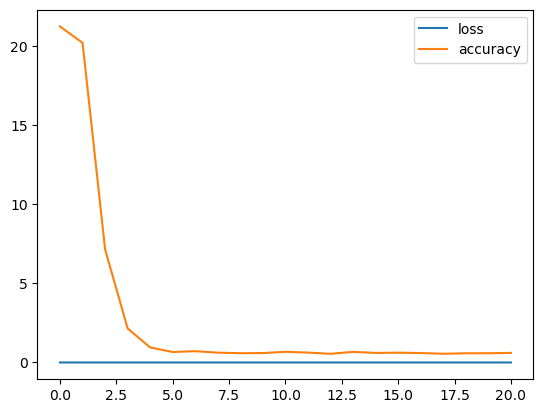

In [ ]:
import matplotlib.pyplot as plt


plt.plot(loss_history, label="loss")
plt.plot(accuracy_history, label="accuracy") 
plt.legend()

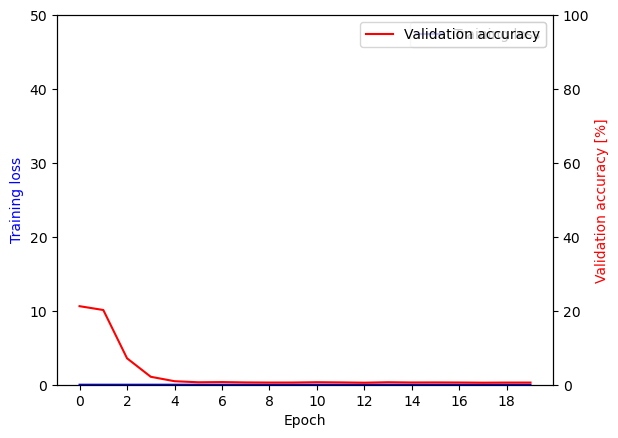

In [ ]:
import matplotlib.pyplot as plt

epoch_cutoff = np.argmin(loss_history)
epoch_cutoff = 20

# Create a figure and primary y-axis
fig, ax1 = plt.subplots()

# Plot data on the primary y-axis
ax1.plot(loss_history[:epoch_cutoff], color='blue', label='Training loss')
ax1.set_ylabel('Training loss', color='blue')
ax1.set_ylim(0, max(loss_history) + 50)

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)

# Plot data on the secondary y-axis
ax2.plot(accuracy_history[:epoch_cutoff], color='red', label='Validation accuracy')
ax2.set_ylabel('Validation accuracy [%]', color='red')

# Add legend
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel("Epoch")
ax1.set_xticks([2 * i for i in range(epoch_cutoff // 2)])
# Show plot
plt.show()